# Goddard problem (julia)

<img src="goddard.jpg" width=417 height=512>

[Thumbnail](goddard.jpg)

This well-known problem (see for instance [1],[2]) models the ascent of a rocket through the atmosphere, and we restrict here ourselves to vertical (one dimensional) trajectories.
The state variables are the altitude, speed and mass of the rocket during the flight, for a total dimension of 3. 
The rocket is subject to gravity, thrust and drag forces. The final time is free, and the objective is to reach a maximal altitude with a bounded fuel consumption.

$$
\left \lbrace
\begin{array}{l}
r(T) \to \max\\
\dot r = v\\
\dot v = \frac{T_\max\,u - D(r,v)}{m} - g_0\\
\dot m = - u\\
u(t) \in [0,1]\\
v(t) \leq v_\max
\end{array}
\right .
$$

The drag term is a function of speed and altitude.
The Hamiltonian is an affine function of the control, so singular arcs may occur, as well as constrained arcs due to the path constraint on the velocity (see below).

**References**

1. R.H. Goddard. A Method of Reaching Extreme Altitudes, volume 71(2) of Smithsonian Miscellaneous Collections. Smithsonian institution, City of Washington, 1919.

2. H. Seywald and E.M. Cliff. Goddard problem in presence of a dynamic pressure limit. Journal of Guidance, Control, and Dynamics, 16(4):776–781, 1993.

## Direct solve

In [20]:
using JuMP, Ipopt, Plots, MINPACK

#JuMP model, Ipopt solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys,"tol",1e-8)
set_optimizer_attribute(sys,"constr_viol_tol",1e-6)
set_optimizer_attribute(sys,"max_iter",1000)

# Parameters
Cd = 310.0
Tmax = 3.5
β = 500.0
b = 2.0
N = 100
t0 = 0.0
r0 = 1.0
v0 = 0.0
vmax = 0.1
m0 = 1.0
x0 = [ r0, v0, m0 ]
mf = 0.6

# Variables (some state constraints have been added to ease convergence)
@variables(sys, begin
    0.0 ≤ Δt                      # time step (unknown as tf is free)
    r[1:N+1] ≥ r0                 # r 
    0 ≤ v[1:N+1] ≤ vmax           # v 
    mf ≤ m[1:N+1] ≤ m0            # m
    0.0 ≤ u[1:N+1] ≤ 1.0          # u
end)

# Objective
@objective(sys, Max, r[N+1])

# Boundary constraints 
@constraints(sys, begin
    con_r0, r[1] == r0
    con_v0, v[1] == v0
    con_m0, m[1] == m0
end)

# Dynamics
@NLexpressions(sys, begin
    # D = Cd v^2 exp(-β(r-1))
    D[i = 1:N+1], Cd * v[i]^2 * exp(-β * (r[i] - 1.0))
    # r'= v
    dr[i = 1:N+1], v[i]
    # v' = (Tmax.u-D)/m - 1/r^2
    dv[i = 1:N+1], (Tmax*u[i]-D[i])/m[i] - 1/r[i]^2
    # m' = -b.Tmax.u
    dm[i = 1:N+1], -b*Tmax*u[i]
end)

# Crank-Nicolson scheme
@NLconstraints(sys, begin
    con_dr[i = 1:N], r[i+1] == r[i] + Δt * (dr[i] + dr[i+1])/2.0
    con_dv[i = 1:N], v[i+1] == v[i] + Δt * (dv[i] + dv[i+1])/2.0
    con_dm[i = 1:N], m[i+1] == m[i] + Δt * (dm[i] + dm[i+1])/2.0
end);

In [21]:
# Solves for the control and state
println("Solving...")
status = optimize!(sys)

if termination_status(sys) == MOI.OPTIMAL
    println("Solution is optimal")
elseif termination_status(sys) == MOI.LOCALLY_SOLVED
    println("Local solution found")
elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
    println("Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("The model was not solved correctly.")
end
println("Objective value = ", objective_value(sys), "\n")

# Retrieves values (including duals - sign convention according to Pontrjagin max principle)
Δtt = value.(Δt)
t = (1:N+1)*Δtt; t = (t[1:end-1] + t[2:end])/2.0
rr = value.(r); rr = (rr[1:end-1] + rr[2:end])/2.0
vv = value.(v); vv = (vv[1:end-1] + vv[2:end])/2.0
mm = value.(m); mm = (mm[1:end-1] + mm[2:end])/2.0
uu = value.(u); uu = (uu[1:end-1] + uu[2:end])/2.0
x =  [ [ rr[i], vv[i], mm[i] ] for i in 1:N ]
p = -[ [ dual(con_dr[i]), dual(con_dv[i]), dual(con_dm[i]) ] for i in 1:N ];

Solving...
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1903
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5700

Total number of variables............................:      405
                     variables with only lower bounds:      102
                variables with lower and upper bounds:      303
                     variables with only upper bounds:        0
Total number of equality constraints.................:      303
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 3.96e-01 4.44e-01  -1.0 0.00e+00    -  0.00e+00

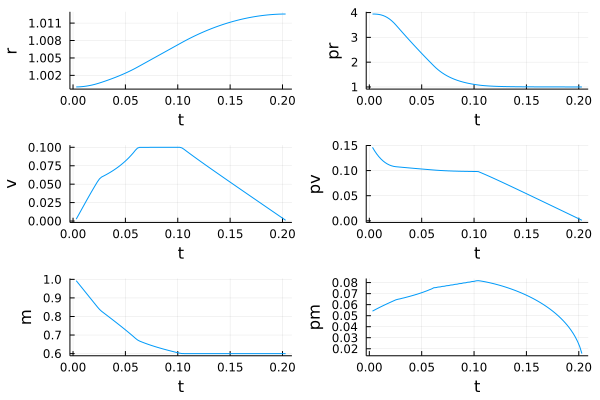

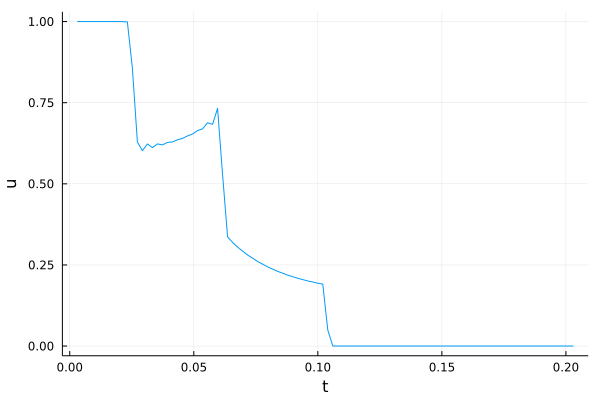

In [22]:
# Plots: state, adjoint state and control
r_plot = plot(t, [ x[i][1] for i in 1:N ], xlabel = "t", ylabel = "r", legend = false)
v_plot = plot(t, [ x[i][2] for i in 1:N ], xlabel = "t", ylabel = "v", legend = false)
m_plot = plot(t, [ x[i][3] for i in 1:N ], xlabel = "t", ylabel = "m", legend = false)
u_plot = plot(t, uu, xlabel = "t", ylabel = "u", legend = false)
pr_plot = plot(t, [ p[i][1] for i in 1:N ], xlabel = "t", ylabel = "pr", legend = false)
pv_plot = plot(t, [ p[i][2] for i in 1:N ], xlabel = "t", ylabel = "pv", legend = false)
pm_plot = plot(t, [ p[i][3] for i in 1:N ], xlabel = "t", ylabel = "pm", legend = false)
x_plot = plot(r_plot, pr_plot, v_plot, pv_plot, m_plot, pm_plot, layout = (3,2))
display(x_plot); savefig(x_plot, "fig1.pdf")
display(u_plot); savefig(u_plot, "fig2.pdf")

## Indirect solve

In [23]:
include("flow.jl")

# Dynamics
function F0(x)
    r, v, m = x
    D = Cd * v^2 * exp(-β*(r-1.0))
    F = [ v, -D/m-1.0/r^2, 0.0 ]
    return F
end

function F1(x)
    r, v, m = x
    F = [ 0.0, Tmax/m, -b*Tmax ]
    return F
end

# Computation of singular control of order 1
H0(x, p) = p' * F0(x) # passer en H0(x, p) = 
H1(x, p) = p' * F1(x)
H01 = Poisson(H0, H1)
H001 = Poisson(H0, H01)
H101 = Poisson(H1, H01)
us(x, p) = -H001(x, p)/H101(x, p)

# Computation of boundary control
g(x) = vmax-x[2] # vmax - v ≥ 0
ub(x) = -Lie(F0, g)(x) / Lie(F1, g)(x)
μb(x, p) = H01(x, p) / Lie(F1, g)(x)

# Hamiltonians (regular, singular, boundary) and associated flows
H(x, p, u, μ) = H0(x, p) + u*H1(x, p) + μ*g(x)
Hr(x, p) = H(x, p, 1.0, 0.0)
Hs(x, p) = H(x, p, us(x, p), 0.0)
Hb(x, p) = H(x, p, ub(x), μb(x, p))

f0 = Flow(H0)
fr = Flow(Hr)
fs = Flow(Hs)
fb = Flow(Hb);

In [24]:
# Shooting function
function shoot(p0, t1, t2, t3, tf) # B+ S C B0 structure

    x1, p1 = fr(t0, x0, p0, t1)
    x2, p2 = fs(t1, x1, p1, t2)
    x3, p3 = fb(t2, x2, p2, t3)
    xf, pf = f0(t3, x3, p3, tf)
    s = zeros(eltype(p0), 7)
    s[1:2] = pf[1:2] - [ 1.0, 0.0 ]
    s[3] = xf[3] - mf # supposed to be active
    s[4] = H1(x1, p1)
    s[5] = H01(x1, p1)
    s[6] = g(x2)
    s[7] = H0(xf, pf) # free tf

    return s

end

shoot (generic function with 1 method)

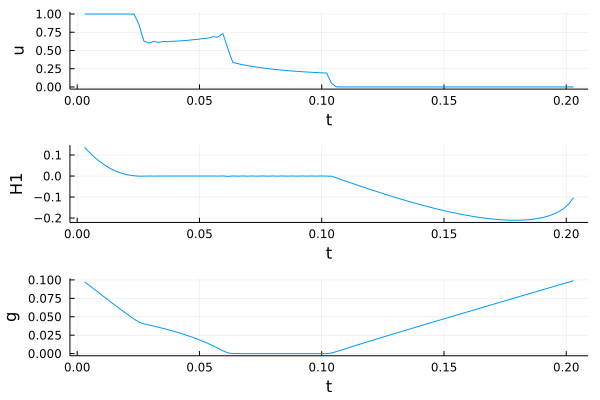

Initial guess:
[3.9428857983400074, 0.14628855388160236, 0.05412448008321635, 0.025246759388000528, 0.061602092906721286, 0.10401664867856217, 0.20298394547952422]


In [25]:
# Initialisation
H1_plot = plot(t, H1.(x, p), xlabel = "t", ylabel = "H1", legend = false)
g_plot = plot(t, g.(x), xlabel = "t", ylabel = "g", legend = false)
display(plot(u_plot, H1_plot, g_plot, layout = (3,1)))
η = 1e-3
t13 = t[ abs.(H1.(x, p)) .≤ η ]
t23 = t[ 0 .≤ g.(x) .≤ η ]
p0 = p[1]
t1 = min(t13...)
t2 = min(t23...)
t3 = max(t23...)
tf = t[end]
ξ = [ p0 ; t1 ; t2 ; t3 ; tf ]

println("Initial guess:\n", ξ)

In [26]:
# Solve
foo(ξ) = shoot(ξ[1:3], ξ[4], ξ[5], ξ[6], ξ[7])
jfoo(ξ) = ForwardDiff.jacobian(foo, ξ)
foo!(s, ξ) = ( s[:] = foo(ξ); nothing )
jfoo!(js, ξ) = ( js[:] = jfoo(ξ); nothing )

println("Initial value of shooting:\n", foo(ξ), "\n\n")

#nl_sol = fsolve(foo!, jfoo!, ξ, show_trace=true); println(nl_sol)
nl_sol = fsolve(foo!, ξ, show_trace=true); println(nl_sol)

# Retrieves solution
if nl_sol.converged
    p0 = nl_sol.x[1:3]
    t1 = nl_sol.x[4]
    t2 = nl_sol.x[5]
    t3 = nl_sol.x[6]
    tf = nl_sol.x[7];
else
    error("Not converged")
end

Initial value of shooting:
[-0.056997602262609304, 0.0018629693255421708, -0.024560747676440786, -0.027013078908617136, -0.21558816837810113, -0.01211467390253125, 0.01571323640576592]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     2.155882e-01     0.000000e+00         0.206675
     2     1.572066e-01     1.781791e-03         1.068728
     3     6.273916e-02     4.415124e-04         0.131722
     4     3.026716e-04     2.824637e-04         0.117245
     5     1.680425e-03     7.268599e-07         0.118732
     6     1.009227e-04     2.772061e-08         0.127807
     7     2.555865e-05     1.768977e-09         0.117719
     8     8.217893e-07     1.316898e-10         0.128705
     9     1.835935e-06     3.436121e-11         0.116216
    10     1.894451e-07     7.180659e-13         0.129818
    11     2.223426e-08     2.539589e-15         0.116257
    12     1.182977e-10     4.901425e-17         0.117955
Result

0.20204744057147958

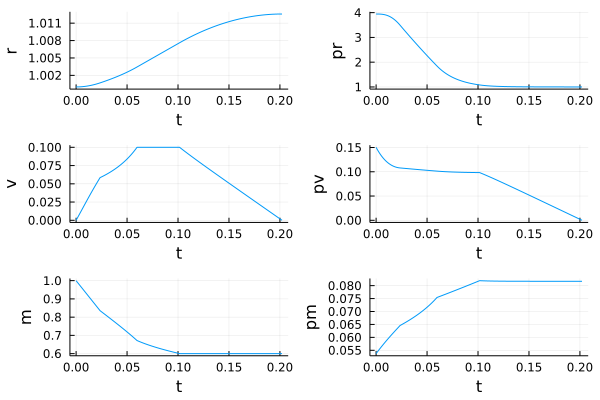

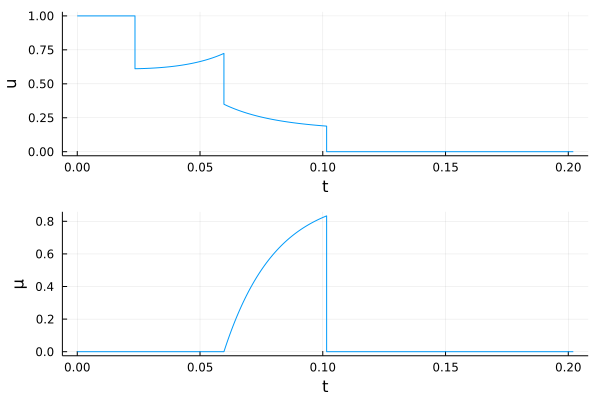

In [27]:
# Plots
ode_sol = fr((t0, t1), x0, p0)
tt0 = ode_sol.t
xx0 = [ ode_sol[1:3, j] for j in 1:size(tt0, 1) ]
pp0 = [ ode_sol[4:6, j] for j in 1:size(tt0, 1) ]
uu0 = ones(size(tt0, 1))
μ0  = zeros(size(tt0, 1))

ode_sol = fs((t1, t2), xx0[end], pp0[end])
tt1 = ode_sol.t
xx1 = [ ode_sol[1:3, j] for j in 1:size(tt1, 1) ]
pp1 = [ ode_sol[4:6, j] for j in 1:size(tt1, 1) ]
uu1 = us.(xx1, pp1)
μ1  = zeros(size(tt1, 1))

ode_sol = fb((t2, t3), xx1[end], pp1[end])
tt2 = ode_sol.t
xx2 = [ ode_sol[1:3, j] for j in 1:size(tt2, 1) ]
pp2 = [ ode_sol[4:6, j] for j in 1:size(tt2, 1) ]
uu2 = ub.(xx2)
μ2  = μb.(xx2, pp2)

ode_sol = f0((t3, tf), xx2[end], pp2[end])
tt3 = ode_sol.t
xx3 = [ ode_sol[1:3, j] for j in 1:size(tt3, 1) ]
pp3 = [ ode_sol[4:6, j] for j in 1:size(tt3, 1) ]
uu3 = zeros(size(tt3, 1))
μ3  = zeros(size(tt3, 1))

t = [ tt0 ; tt1 ; tt2 ; tt3 ]
x = [ xx0 ; xx1 ; xx2 ; xx3 ]
p = [ pp0 ; pp1 ; pp2 ; pp3 ]
u = [ uu0 ; uu1 ; uu2 ; uu3 ]
μ = [ μ0  ; μ1  ; μ2  ; μ3  ]
N = length(t)

r_plot  = plot(t, [ x[i][1] for i=1:N ], xlabel = "t", ylabel = "r", legend = false)
v_plot  = plot(t, [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "v", legend = false)
m_plot  = plot(t, [ x[i][3] for i=1:N ], xlabel = "t", ylabel = "m", legend = false)
pr_plot = plot(t, [ p[i][1] for i=1:N ], xlabel = "t", ylabel = "pr", legend = false)
pv_plot = plot(t, [ p[i][2] for i=1:N ], xlabel = "t", ylabel = "pv", legend = false)
pm_plot = plot(t, [ p[i][3] for i=1:N ], xlabel = "t", ylabel = "pm", legend = false)
u_plot  = plot(t, u, xlabel = "t", ylabel = "u", legend = false)
μ_plot  = plot(t, μ, xlabel = "t", ylabel = "μ", legend = false)
x_plot = plot(r_plot, pr_plot, v_plot, pv_plot, m_plot, pm_plot, layout = (3,2))
umu_plot = plot(u_plot, μ_plot, layout = (2,1))
display(x_plot); savefig(x_plot, "fig5.pdf")
display(umu_plot); savefig(umu_plot, "fig6.pdf")